In [1]:
import pandas as pd
import numpy as np
import csv
from copy import deepcopy
from pandas import datetime
from copy import deepcopy
import gc
import random
import datetime
import csv
from copy import deepcopy
from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm_notebook
from Downloader import Extractor
from Preprocessing import Preprocessor, set_onelevel, set_multilevel
from Filters import XGB_Quantile
from Filters import quantile_huber_loss, quantile_huber_obj 
import pickle
import xgboost as xgb
from Solar import AddSolarAngles
import matplotlib.pyplot as plt

# Data with anomalies

In [2]:
# getting file tree in directory "data_csv", which contains raw unfiltered data
mypath = '/home/ndsviriden/data_csv/Raw'
dateparse = pd.to_datetime
station_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) if int(f.split('_', 1)[0])]
station_files.sort()

# reading loaded csv files from data_csv directory, output is a list (length=number of stations) of raw df 
raw_lmeteo_list = [pd.read_csv(mypath + '/' + station, index_col=0, 
                    dtype={'station_id': int,'date_time': str}, 
                    date_parser = dateparse, parse_dates = ['date_time']) 
                   for station in tqdm_notebook(station_files[40:])]

#fix problems with indexing, later this will be solved in loading part
for elem in raw_lmeteo_list:
    elem.reset_index(drop=True, inplace=True)

raw_data = pd.concat(raw_lmeteo_list)
raw_data['id'] = random.sample(range(len(raw_data)), len(raw_data))
raw_data['valid'] = True
raw_data = raw_data.reset_index(drop=True)

del raw_lmeteo_list
gc.collect()

raw_data

,station_data_id,sensor_id,data,station_id,sensor_type_id,active_state,name,rule_id,rule_ordr,direction,lane_traffic,date_time,poll_interval,fake_data,type,unit_of_measure,description,id,valid
0,5315175.0,5119.0,719.0,593,16.0,I,NaN,189.0,26.0,0.0,0.0,2012-03-01 07:34:33,NaN,NaN,pressure,NaN,pressure (sw),7321435,True
1,5315175.0,5110.0,-18.0,593,2.0,I,NaN,180.0,8.0,0.0,0.0,2012-03-01 07:34:33,NaN,NaN,t_road,NaN,t_road (sw),4646023,True
2,5315175.0,5109.0,-13.0,593,1.0,I,NaN,179.0,6.0,0.0,0.0,2012-03-01 07:34:33,NaN,NaN,t_air,NaN,t_air (sw),5386126,True
3,5315175.0,5111.0,-18.0,593,3.0,I,NaN,180.0,10.0,0.0,0.0,2012-03-01 07:34:33,NaN,NaN,t_underroad,NaN,t_underroad (sw),115168,True
4,5315175.0,5112.0,903.0,593,4.0,I,NaN,182.0,12.0,0.0,0.0,2012-03-01 07:34:33,NaN,NaN,dampness,NaN,dampness (sw),9162784,True
5,5315309.0,5119.0,719.0,593,16.0,I,NaN,189.0,26.0,0.0,0.0,2012-03-01 07:58:35,NaN,NaN,pressure,NaN,pressure (sw),3219947,True
6,5315309.0,5110.0,-17.0,593,2.0,I,NaN,180.0,8.0,0.0,0.0,2012-03-01 07:58:35,NaN,NaN,t_road,NaN,t_road (sw),8311514,True
7,5315309.0,5109.0,-13.0,593,1.0,I,NaN,179.0,6.0,0.0,0.0,2012-03-01 07:58:35,NaN,NaN,t_air,NaN,t_air (sw),2381112,True
8,5315309.0,5111.0,-17.0,593,3.0,I,NaN,180.0,10.0,0.0,0.0,2012-03-01 07:58:35,NaN,NaN,t_underroad,NaN,t_underroad (sw),3557405,True
9,5315309.0,5112.0,903.0,593,4.0,I,NaN,182.0,12.0,0.0,0.0,2012-03-01 07:58:35,NaN,NaN,dampness,NaN,dampness (sw),6288035,True


In [3]:
preprocessor = Preprocessor()
meteo_split = preprocessor.PivotTable(raw_data)
patterns_list = preprocessor.CreatePatternList(meteo_split)
patterns_interpolated = preprocessor.InterpolatePatterns(patterns_list)
patterns_interpolated = [pattern for pattern in patterns_interpolated if len(pattern > 0)]
patterns_solar = AddSolarAngles(patterns_interpolated)
patterns_lagged = preprocessor.CreateLaggedTable(patterns_solar)
del meteo_split, patterns_list, patterns_interpolated, patterns_solar

/home/ndsviriden/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


# Data with anomalies. From file 

In [2]:
final_anomaly = pd.read_csv('/home/ndsviriden/data_csv/full_lagged_angles.csv', header=[0, 1], skipinitialspace=True, tupleize_cols=True, index_col=0)
columns = [(elem[0], float(elem[1])) for elem in final_anomaly.columns]
final_anomaly.columns = pd.MultiIndex.from_tuples(columns)
final_anomaly[('date_time', 0)] = pd.to_datetime(final_anomaly[('date_time', 0)])

/home/ndsviriden/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Filtered data

In [ ]:
df = pd.read_csv('clean_data.csv', header=[0, 1], skipinitialspace=True, tupleize_cols=True, index_col=0)
columns = [(elem[0], '') if elem[0] in ('date_time', 'station_id') else elem for elem in df.columns]
df.columns = pd.MultiIndex.from_tuples(columns)
df[('date_time', '')] = pd.to_datetime(df[('date_time', '')])

preprocessor = Preprocessor()
patterns_interpolated = preprocessor.CreatePatternList(df, min_length=pd.Timedelta('0h'))
patterns_solar = AddSolarAngles(patterns_interpolated)
patterns_lagged_clean = preprocessor.CreateLaggedTable(patterns_solar)
del df, patterns_interpolated, patterns_solar

In [5]:
from Filters import create_xgb_matrix 
final_clean = pd.concat(patterns_lagged_clean)

test_label = 't_road'

train_clean = final_clean[final_clean[('date_time', 0)] < '2015-06']
val_clean = final_clean[final_clean[('date_time', 0)] >= '2015-06']

dtrain = create_xgb_matrix(train_clean, test_label)
dval = create_xgb_matrix(val_clean, test_label)
dfinal = create_xgb_matrix(final_clean, test_label)

In [6]:
from Filters import create_xgb_matrix 
#final_anomaly = pd.concat(patterns_lagged_clean)

test_label = 't_road'

train_anomaly = final_anomaly[final_anomaly[('date_time', 0)] < '2015-06']
train_anomaly = train_anomaly[train_anomaly[('station_id', 0)] < 506]
val_anomaly = final_anomaly[final_anomaly[('date_time', 0)] >= '2015-06']
train_anomaly = train_anomaly[train_anomaly[('station_id', 0)] < 506]

dtrain = create_xgb_matrix(train_anomaly, test_label)
dval = create_xgb_matrix(val_anomaly, test_label)
dfinal = create_xgb_matrix(final_anomaly, test_label)

In [7]:
train_anomaly[('station_id', 0)].unique()

array([113, 114, 115, 116, 302, 303, 304, 308, 309, 442, 502, 503, 504, 505])

In [8]:
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from functools import partial
from Filters import quantile_huber_loss, quantile_huber_obj

params = {}

params["eval_metric"] = 'mae'
params["eta"] = 0.05
params["lambda"] = 0.3
params["subsample"] = 0.8 #1
params["min_child_weight"] = 1.
params["colsample_bytree"] = 0.5
params["max_depth"] = 9
params["silent"] = 1
params["gamma"] = 0.1
delta = 1.
#delta = 1.
watchlist = [(dtrain, 'train'), (dval, 'valid')]

#-----------------------------------------------------------------------------------------------
print('-----------MEDIAN-----------')
clf_dirty = xgb.train(params, dtrain, 600, watchlist, verbose_eval=20)

-----------MEDIAN-----------
[0]	train-mae:134.326	valid-mae:142.994
[20]	train-mae:48.379	valid-mae:51.2672
[40]	train-mae:17.6769	valid-mae:18.6002
[60]	train-mae:7.08812	valid-mae:7.57855
[80]	train-mae:3.85555	valid-mae:4.539
[100]	train-mae:3.02159	valid-mae:3.8898
[120]	train-mae:2.78099	valid-mae:3.72902
[140]	train-mae:2.67002	valid-mae:3.65279
[160]	train-mae:2.59525	valid-mae:3.60499
[180]	train-mae:2.54083	valid-mae:3.57324
[200]	train-mae:2.50054	valid-mae:3.55827
[220]	train-mae:2.46569	valid-mae:3.53601
[240]	train-mae:2.43229	valid-mae:3.51885
[260]	train-mae:2.40063	valid-mae:3.49856
[280]	train-mae:2.37242	valid-mae:3.48362
[300]	train-mae:2.33953	valid-mae:3.46404
[320]	train-mae:2.30927	valid-mae:3.44555
[340]	train-mae:2.28256	valid-mae:3.42908
[360]	train-mae:2.26017	valid-mae:3.4202
[380]	train-mae:2.23612	valid-mae:3.40661
[400]	train-mae:2.21542	valid-mae:3.3958
[420]	train-mae:2.19061	valid-mae:3.38346
[440]	train-mae:2.16247	valid-mae:3.36303
[460]	train-mae:2

In [10]:
import pickle
test_label = 't_road'
path = '/home/ndsviriden/estimators/' + test_label
pickle.dump(clf, open(path + '_median', 'wb'))
#pickle.dump(clf_upper, open(path + '_mean', 'wb'))
#pickle.dump(clf_lower, open(path + '_lower', 'wb'))

In [3]:
import pickle
test_label = 't_road'
clf = pickle.load(open('/home/ndsviriden/estimators/'+test_label+'_median', 'rb'))

In [4]:
final_anomaly[('station_id', 0)].unique()
final_anomaly = final_anomaly[final_anomaly[('station_id', 0)].isin((113,  114,  115,  302,  308,  309,  442,  502,
                            503,  504,  507,  511,  512,  513, 1820, 1832,
                            1836, 1838,  593,  596,  597,  612,  613,
                            615,  616,  621,  622, 626,  627,  628,
                            836,  837,  838,  839,  862,  874))]

In [5]:
final_anomaly[('station_id', 0)].unique()

array([ 113,  114,  115,  302,  308,  309,  442,  502,  503,  504,  507,
        511,  512,  513, 1820, 1832, 1836, 1838,  593,  596,  597,  612,
        613,  615,  616,  621,  622,  626,  627,  628,  836,  837,  838,
        839,  862,  874])

In [6]:
from Filters import create_xgb_matrix 
#final_anomaly = pd.concat(patterns_lagged)

test_label = 't_road'

#train_anomaly = final_anomaly[final_anomaly[('date_time', 0)] < '2015-06']
#val_anomaly = final_anomaly[final_anomaly[('date_time', 0)] >= '2015-06']

#dtrain = create_xgb_matrix(train, test_label)
#dval = create_xgb_matrix(val, test_label)
dfinal_anomaly = create_xgb_matrix(final_anomaly, test_label)

In [7]:
import numpy as np
import pickle
import xgboost as xgb
from copy import deepcopy
from Preprocessing import set_onelevel, set_multilevel, UnLagTable
from matplotlib import pyplot as plt

def UnLagTable(df_lagged):
    df = df_lagged.loc[:, df_lagged.columns.get_level_values(1).isin({0})]
    df.columns = df.columns.droplevel(1)
    df = set_multilevel(df)
    return df


def create_xgb_matrix(df, test_label, include_labels=True):
    features = [col for col in df.columns.levels[0] if col.startswith('data_')]

    X_lag = np.arange(-6, 0, 0.5)
    add = [(col, 0) for col in features if (col != 'data_' + test_label)]

    X_label = [(feature, lag) for feature in features for lag in X_lag] + add
    y_label = [('data_' + test_label, 0)]

    X = df[X_label].values
    y = df[y_label].values.reshape(-1, 1)
    
    if include_labels:
        dxgb = xgb.DMatrix(X, y)
    else:
        dxgb = xgb.DMatrix(X)

    return dxgb

def plot_filter_result(df_filtered, station, start='2012-01-01', end='2016-01-01', sensors=['t_road']):
    df = UnLagTable(df_filtered)
    print(df.columns)

    # selecting the exact station and time interval
    df_plot = df[df['station_id'] == station]
    df_plot = df_plot[(df_plot['date_time'] >= start) & (df_plot['date_time'] <= end)]

    color = ['b', 'g', 'm']
    i = 0
    plt.figure(figsize=(30, 10))
    for sensor in sensors:
        for elem in [True, False]:
            cond = df_plot[('valid', sensor)] == elem
            
            if elem:
                plt.plot_date(df_plot[cond].date_time, df_plot[cond][('data', sensor)], color[i],
                              linestyle='none', marker='o', label=sensor, markersize=6)

            else:
                plt.plot_date(df_plot[cond].date_time, df_plot[cond][('data', sensor)], 'r.',
                              linestyle='none', marker='o', label='_nolegend_', markersize=6)
        #plt.plot(df_plot.date_time, df_plot[('upper_'+ test_label, '')], 'b', linestyle='-')
        #plt.plot(df_plot.date_time, df_plot[('lower_'+ test_label, '')], 'b', linestyle='-')
        i += 1

    plt.title(sensor, fontsize=24)
    plt.legend(loc='upper right', fontsize=14)
    plt.grid(which='both')
    plt.show()
    pass

In [12]:
from sklearn.metrics import mean_absolute_error as mae
y_true = dtrain.get_label().reshape(-1, 1)
y_pred = clf_dirty.predict(create_xgb_matrix(train_anomaly, test_label, include_labels=False))
std = np.std(y_true.ravel() - y_pred.ravel())
print(std)

3.11382


In [8]:
y_true = dfinal_anomaly.get_label().reshape(-1, 1)
#del dfinal_anomaly, patterns_lagged
y_pred = clf.predict(create_xgb_matrix(final_anomaly, test_label, include_labels=True))

std = 3.11
y_upper = y_pred.ravel() + 12 * std
y_lower = y_pred.ravel() - 12 * std
df_filtered = deepcopy(final_anomaly)

df_filtered[('valid_' + test_label, 0)] = ((y_true.ravel() < y_upper) & (y_true.ravel() > y_lower))
df_filtered[('upper_'+test_label, 0)] = y_upper
df_filtered[('lower_' + test_label, 0)] = y_lower

In [9]:
final_anomaly[('station_id', 0)].unique()

array([ 113,  114,  115,  302,  308,  309,  442,  502,  503,  504,  507,
        511,  512,  513, 1820, 1832, 1836, 1838,  593,  596,  597,  612,
        613,  615,  616,  621,  622,  626,  627,  628,  836,  837,  838,
        839,  862,  874])

MultiIndex(levels=[['data', 'date_time', 'id', 'lower_t_road', 'station_id', 'upper_t_road', 'valid'], ['', 'altitude', 'azimuth', 'dampness', 'pressure', 't_air', 't_road', 't_underroad']],
           labels=[[6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4, 1, 3, 5], [4, 6, 5, 7, 3, 4, 6, 5, 7, 3, 4, 6, 5, 1, 7, 3, 2, 0, 0, 0, 0]])


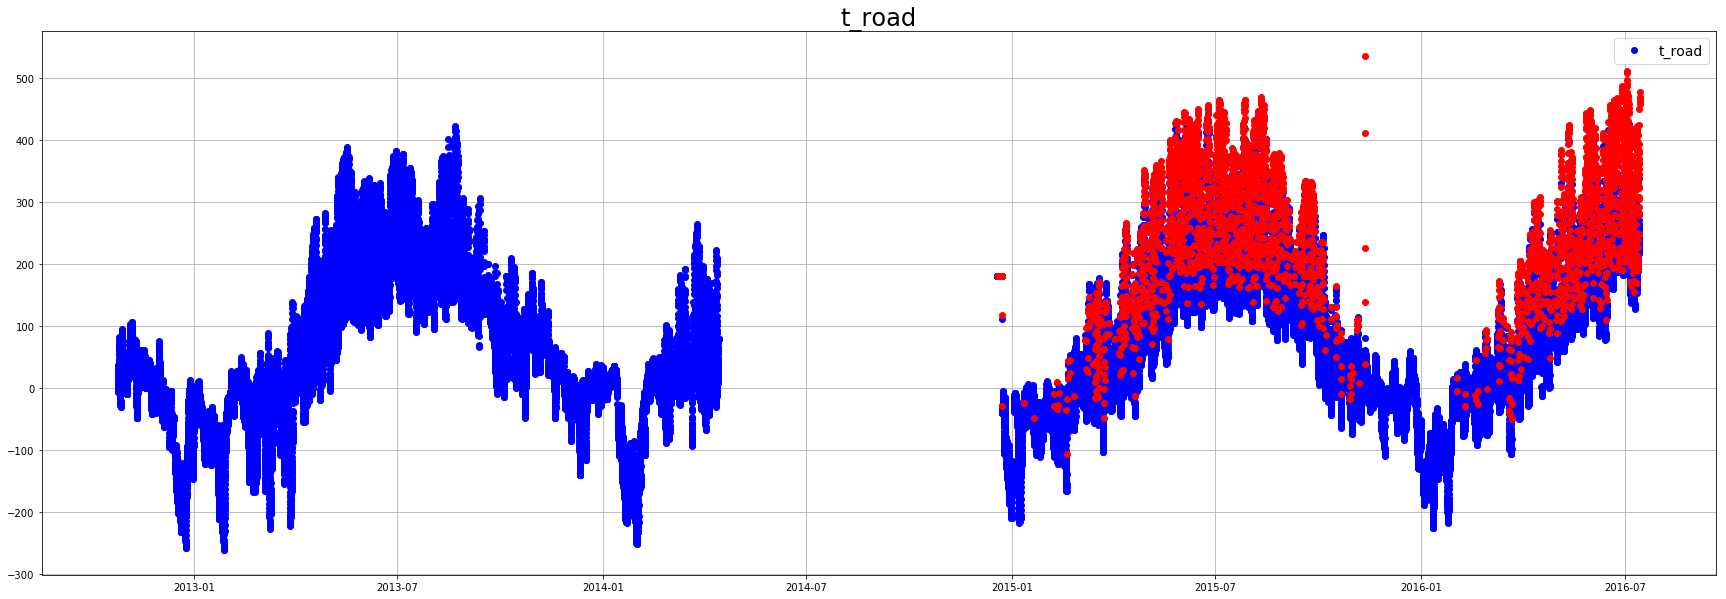

In [63]:
plot_filter_result(df_filtered, station=612, start='2012-01-01', end='2016-08-01', sensors=['t_road'])

MultiIndex(levels=[['data', 'date_time', 'id', 'lower_t_road', 'station_id', 'upper_t_road', 'valid'], ['', 'altitude', 'azimuth', 'dampness', 'pressure', 't_air', 't_road', 't_underroad']],
           labels=[[6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4, 1, 3, 5], [4, 6, 5, 7, 3, 4, 6, 5, 7, 3, 4, 6, 5, 1, 7, 3, 2, 0, 0, 0, 0]])


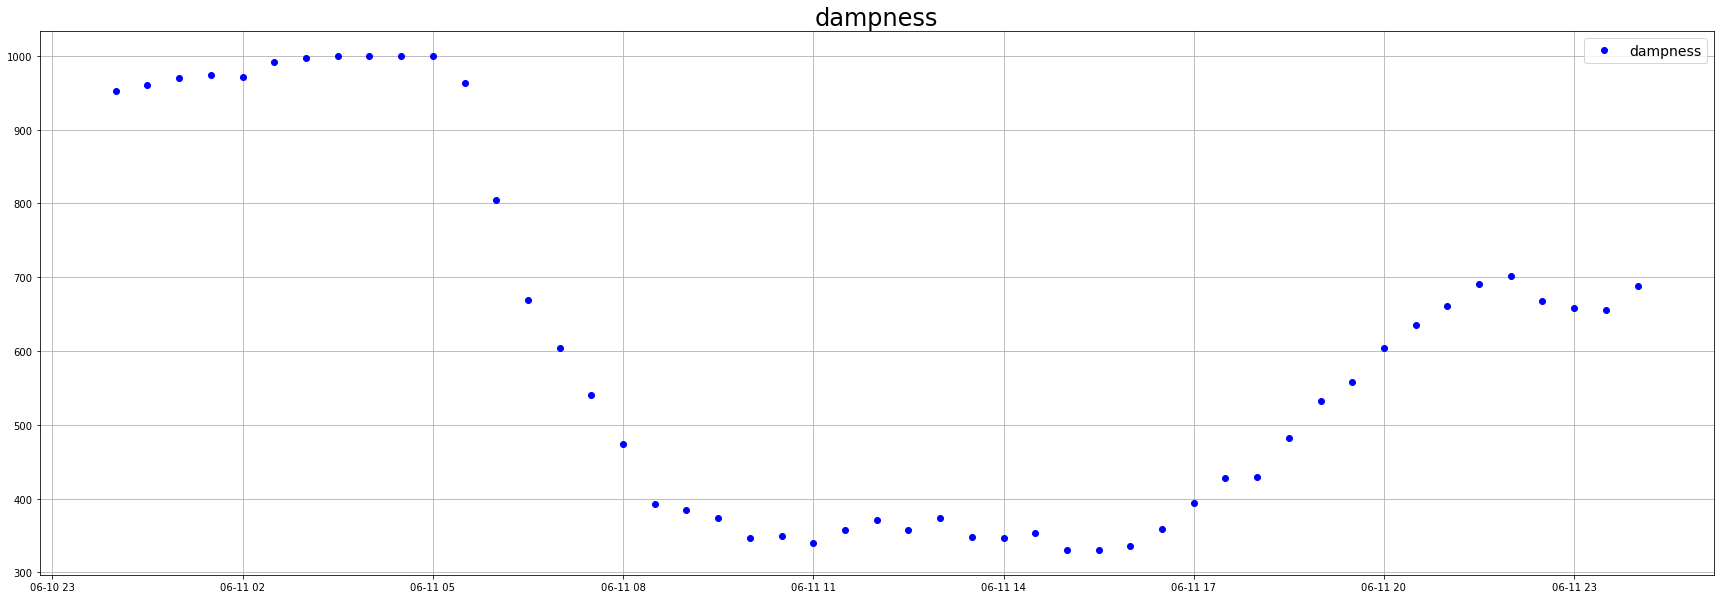

In [25]:
plot_filter_result(df_filtered, station=612, start='2015-06-11', end='2015-06-12', sensors=['dampness'])

MultiIndex(levels=[['data', 'date_time', 'id', 'lower_t_road', 'station_id', 'upper_t_road', 'valid'], ['', 'altitude', 'azimuth', 'dampness', 'pressure', 't_air', 't_road', 't_underroad']],
           labels=[[6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4, 1, 3, 5], [4, 6, 5, 7, 3, 4, 6, 5, 7, 3, 4, 6, 5, 1, 7, 3, 2, 0, 0, 0, 0]])


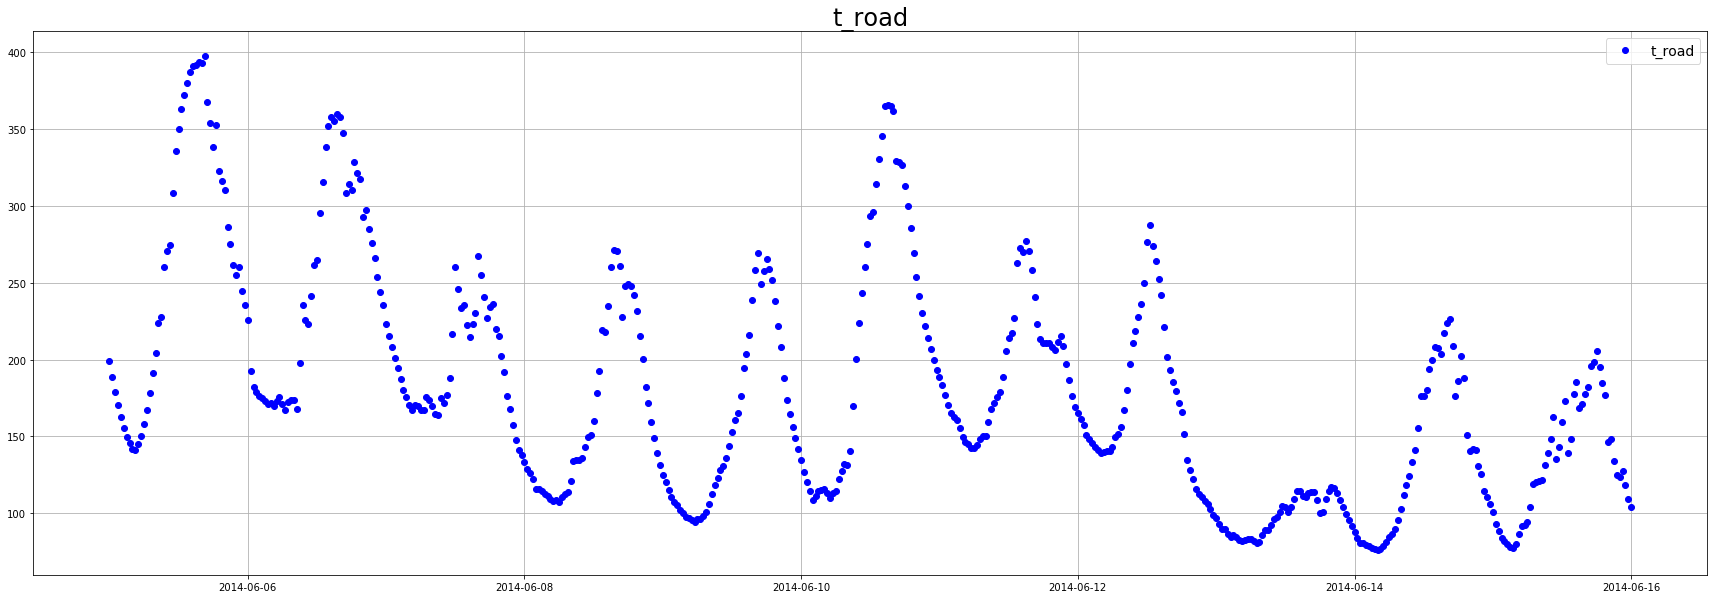

In [9]:
plot_filter_result(df_filtered, station=1832, start='2014-06-05', end='2014-06-16', sensors=['t_road'])

## Interval regression

In [ ]:
'''
#-----------------------------------------------------------------------------------------------
print('-----------UPPER-----------')
alpha = 0.995
params["lambda"] = 4.0
params["subsample"] = 0.7
params["max_depth"] = 5
params["colsample_bytree"] = 0.5
clf_upper = xgb.train(params, dtrain, 600, watchlist, partial(quantile_huber_obj, _alpha=alpha, _delta=delta), 
                partial(quantile_huber_loss, _alpha=alpha, _delta=delta), 
                verbose_eval=50)
train_upper = clf_upper.predict(dtrain)
val_upper = clf_upper.predict(dval)

#-----------------------------------------------------------------------------------------------
print('-----------LOWER-----------')
alpha = 0.005
params["max_depth"] = 7
params["colsample_bytree"] = 0.5
params["lambda"] = 1.0
clf_lower = xgb.train(params, dtrain, 500, watchlist, partial(quantile_huber_obj, _alpha=alpha, _delta=delta), 
                partial(quantile_huber_loss, _alpha=alpha, _delta=delta), 
                verbose_eval=50)
train_lower = clf_lower.predict(dtrain)
val_lower = clf_lower.predict(dval)'''